In [78]:
import random
from itertools import chain, cycle, islice
import torch
from torch.utils.data import *
import time
import torch.utils.data as data
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import datetime

In [79]:
n_colors = 8
colors_list = [(i / (2 + n_colors) , i / (2 + n_colors), 0.8 ) for i in range(n_colors)]
colors = { f'M{i + 1}' : colors_list[i] for i in range(n_colors) }

def count(start=0, step=1):
    # count(10) --> 10 11 12 13 14 ...
    # count(2.5, 0.5) -> 2.5 3.0 3.5 ...
    n = start
    while True:
        yield n
        n += step
        
def scalar(x):
    return x.item() if hasattr(x, 'item') else x

def plot_multi_timings(loader, n_batches, modes, model_time = 0.2, max_time = 2.5, zero_time = None, intervals = []):
    fig, ax = plt.subplots()
    
    if zero_time is None:
        zero_time = time.time()
    
    worker_ids = {}
    worker_count = count()
    
    k = 0
    for data_dict, worker_dict, start_dict, end_dict in islice(loader, n_batches):
        run_start = time.time()
        time.sleep(model_time)
        run_end = time.time()
        
        
        for mode in modes:
            data = data_dict[mode]
            worker = worker_dict[mode]
            start = start_dict[mode]
            end = end_dict[mode]
            
            for item in zip(data, worker, start, end):
                data_, worker_, start_, end_ = tuple(map(scalar, item))
                if worker_ != -1:
                    if worker_ not in worker_ids:
                        worker_ids[worker_] = next(worker_count)
                    worker_ = worker_ids[worker_]
                    
                plot_time_box(data_, worker_, start_ - zero_time, end_ - zero_time, ax, color=colors[mode])
            
        plot_time_box(str(k), -1, run_start - zero_time, run_end - zero_time, ax, color = 'red')
        k += 1
        
    max_worker = loader.num_workers - 1
    
    
    ax.set_axisbelow(True)
    ax.yaxis.grid(which="major", color='black', linewidth=1)
    ax.xaxis.grid(which="major", color='gray', linewidth=1, linestyle='--')
    ax.xaxis.set_minor_formatter('{x:.1f}')
    
    ax.set_xlim(0, max_time)
    ax.set_ylim(-1.5, max_worker + 0.5)
    ax.set_xticks(intervals)
    ax.set_xticks(np.arange(0, max_time, 0.2), minor=True)
    ax.set_yticks(np.arange(-1, max_worker+1, 1))
    ax.set_yticklabels([])
    ax.tick_params(axis='y', colors=(0,0,0,0))
    
    fig.set_figwidth(16)
    fig.set_figheight((max_worker + 2) * 0.5)
    
    ax.xaxis.label.set_color('gray')
    ax.tick_params(which='both', axis='x', colors='gray')
    for spine in ax.spines.values():
        spine.set_edgecolor((0,0,0,0))
                
def plot_time_box(data, worker, t1, t2, ax, color='steelblue'):
    x = t1
    y = worker - 0.25
    w = t2 - t1
    h = 0.6
    
    rect = Rectangle((x, y), w, h, linewidth=2, edgecolor='black',facecolor=color)
    
    ax.add_patch(rect)
    
    ax.text(x + (w * 0.5), y + (h * 0.5), str(data), va='center', ha='center', color='white', weight='bold') 
    
def wait_until(end_time):
    while True:
        diff = (end_time - time.time())
        if diff < 0: return
        time.sleep(diff/2)
        if diff <= 0.01: return

In [96]:
n_modes = 4
modes = [f'M{i + 1}' for i in range(n_modes)]
process_times = { mode : random.random() * 0.4 + 0.1 for mode in modes }
data_dict = { mode : [f'{mode}-{i}' for i in range(16)] for mode in modes }
intervals = [0.6 * i for i in range(100)]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8d7a501ab0>
Traceback (most recent call last):
  File "/gallery_uffizi/sehun.lee/miniconda3/envs/aisys/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/gallery_uffizi/sehun.lee/miniconda3/envs/aisys/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/gallery_uffizi/sehun.lee/miniconda3/envs/aisys/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/gallery_uffizi/sehun.lee/miniconda3/envs/aisys/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/gallery_uffizi/sehun.lee/miniconda3/envs/aisys/lib/python3.10/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/gallery_uffizi/sehun

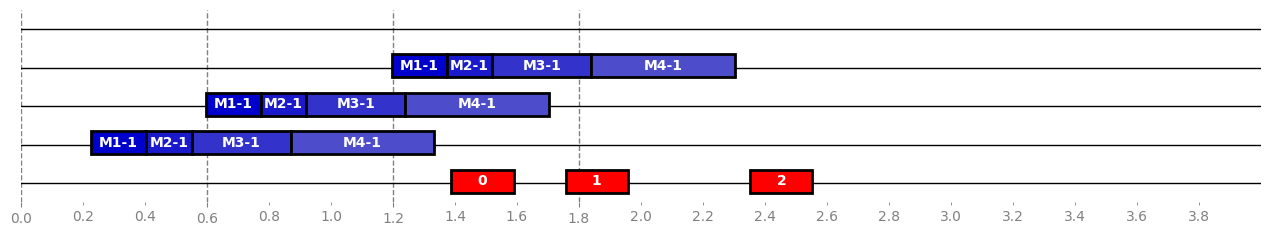

In [100]:
class CustomMultimodalDataset(IterableDataset):
    def __init__(self, data_dict, modes, process_times = None):
        self.data_dict = data_dict
        self.modes = modes
        if process_times is None:
            self.process_times = { mode : 0.1 for mode in modes }
        else:
            self.process_times = process_times
    
    def __iter__(self):
        index = 0
        while True:
            worker = torch.utils.data.get_worker_info()
            worker_id = worker.id if worker is not None else -1
            
            wait_until(next_times[4 * index + worker_id])
            index += 1
            
            data_dict = {}
            worker_dict = {}
            start_dict = {}
            end_dict = {}
            for mode in self.modes:
                start_dict[mode] = time.time()
                time.sleep(self.process_times[mode])
                data_dict[mode] = self.data_dict[mode][index]
                end_dict[mode] = time.time()
                worker_dict[mode] = worker_id

            yield data_dict, worker_dict, start_dict, end_dict

dataset = CustomMultimodalDataset(data_dict, modes, process_times)
loader = DataLoader(dataset, batch_size = 1, num_workers = 4, drop_last = True, prefetch_factor = 1)

zero_time = time.time()
next_times = [zero_time + i for i in intervals]

plot_multi_timings(loader, n_batches = 3, modes = modes, zero_time = zero_time, max_time = 4.0, intervals = intervals[:4])

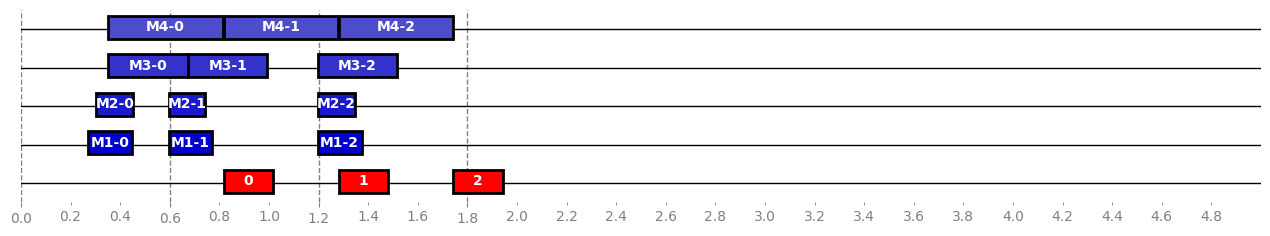

In [111]:
class CustomUnimodalDataset(IterableDataset):
    def __init__(self, data, mode, process_time = None):
        self.data = data
        self.mode = mode
        if process_time is None:
            self.process_time = 0.1
        else:
            self.process_time = process_time
    
    def __iter__(self):
        j = 0
        for data in self.data:
            global next_times
            wait_until(next_times[j])
            worker = torch.utils.data.get_worker_info()
            worker_id = worker.id if worker is not None else -1
            
            # Data Processing Time
            start = time.time()
            time.sleep(self.process_time)
            end = time.time()
            
            yield data, worker_id, start, end
            
            j += 1
            
    
class MultimodalDataLoaderWrapper:
    def __init__(self, datasets, modes):
        self.datasets = datasets
        self.modes = modes
        self.num_workers = len(modes)
    
    def get_data_loaders(self):
        return zip(*[DataLoader(dataset, num_workers = 1, batch_size = None, prefetch_factor = 1) for dataset in self.datasets])
    
    def __iter__(self):
        for batch_parts in self.get_data_loaders():
            data_dict = {}
            worker_id = {}
            start_dict = {}
            end_dict = {}
            i = 0
            for (data, wid, start, end), mode in zip(batch_parts, self.modes):
                data_dict[mode] = [data]
                worker_id[mode] = [wid + i]
                start_dict[mode] = [start]
                end_dict[mode] = [end]
                i += 1
            
            yield data_dict, worker_id, start_dict, end_dict
            
datasets = [ CustomUnimodalDataset(data_dict[mode], mode, process_times[mode]) for mode in modes ] 

loader = MultimodalDataLoaderWrapper(datasets, modes)

zero_time = time.time()
next_times = [zero_time + i for i in intervals]

plot_multi_timings(loader, n_batches = 3, modes = modes, zero_time = zero_time, max_time = 5.0, intervals = intervals[:4])